# 📊 공모주 커뮤니티 Intent 분석
공모주 커뮤니티 게시글을 규칙 기반 Intent로 분류하여
성수기 중심 대화 구조를 파악하고,
비수기에도 체류를 유지할 수 있는 참여형 콘텐츠 방향을 도출한다.

# 0️⃣ 라이브러리 로드

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import koreanize_matplotlib

# 1️⃣ 데이터 로드 및 기본 전처리

In [2]:
df = pd.read_excel("./data/커뮤니티.xlsx")
df = df.drop('date', axis=1)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          947 non-null    int64 
 1   title        947 non-null    object
 2   description  938 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.3+ KB


# 2️⃣ 텍스트 정제

In [3]:
import re

def text_clean(x):
    # 한글, 영문대소문자, 숫자만 남기고 모두 제거
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]', " ", x)
    cleaned = cleaned.replace("  ", " ").replace("  ", " ").strip()
    return cleaned

In [4]:
df['title'] = df['title'].astype(str).apply(text_clean)
df['description'] = df['description'].astype(str).apply(text_clean)

df.head()

,No.,title,description
0,1985,작년 불장에 수익률,저는 운 좋게도 방산주 반도체주 조선주 에너지주 ETF로 평
1,1984,한달전 공모주 리브스메드,작년 12월 24일 상장한 리브스메드 최고가 찍었어요2개 6600
2,1983,1 2월 공모주 흉년이네요,원래 상반기는 공모주가 별로없나요 아쉽네요
3,1982,케이뱅크,예전에 케이뱅크이벤트로 2주 받은게있는데 나무증권에 입고되어있더라
4,1981,포인트는 어디에 쓰나요,안녕하세요 방금 가입했는데 포인트는 어디에쓰나


# 3️⃣ 제외 단어 설정 및 단어 빈도 확인

In [5]:
stopwords = [
    '오늘','다들','저는','안녕하세요','감사합니다',
    '많이','잘','더','다','모두','왜','어떻게',
    '너무','조금','아직','지금','내일','어제',
    '계속','했는데','올해'
]

from collections import Counter

text_all = " ".join(df['description'].astype(str))
words = text_all.split()

filtered_words = [w for w in words if w not in stopwords]

Counter(filtered_words).most_common(30)

[('공모주', 67),
 ('매도', 30),
 ('청약', 23),
 ('균등', 23),
 ('1주', 22),
 ('공모가', 18),
 ('시초가', 13),
 ('스팩', 12),
 ('또', 11),
 ('공모주로', 10),
 ('배정', 10),
 ('요즘', 10),
 ('안', 10),
 ('하시나요', 10),
 ('공모주가', 9),
 ('좀', 9),
 ('수익', 9),
 ('피너츠', 9),
 ('분위기', 9),
 ('수', 9),
 ('전', 9),
 ('못', 9),
 ('하는', 9),
 ('nan', 9),
 ('받았네요', 8),
 ('오늘도', 8),
 ('좋은', 8),
 ('상장', 8),
 ('바로', 8),
 ('매도했어요', 8)]

# 4️⃣ Intent 분류 규칙 정의 (Rule-based Classification)

In [6]:
intent_dict = {
    '시장반응': ['공모주','청약','균등','비례','배정','공모가','시초가','상장','따상','스팩','매도','매수','주가',
                 '수익률','물량','청약률','경쟁률'],
    '정보질문': ['언제','지금','내일','오늘','어떻게','가능','방법','문의','할까요','해야','해도','되나요',
                 '몇주','몇 주','몇개','받나요','처음','처음인데','괜찮나요','팔아','매도해','사도','들어가'],
    '이벤트대화': ['이벤트','참여','응모','당첨','포인트','쿠폰','리워드','경품','출석','미션','룰렛', '로또', '주식로또'],
    '경험공유': ['받았','받음','완료','인증','수익','익절','손절','매도완료','팔았','샀어요','배정받','성공','결과'],
    '이슈불만건의': ['오류','안됨','왜이럼','문제','버그','안열','느림','로그인','튕김','불편','이상','건의','개선'
                 '관리자','왜']}

# 5️⃣ Intent 분류 함수

In [7]:
# 의도 분류 함수
def classify_intent(title, desc):
    text = f"{title} {desc}"

    # 1️⃣ 질문 먼저
    for kw in intent_dict['정보질문']:
        if kw in text:
            return '정보질문'
        
    # 1️⃣ 이슈불만건의
    for kw in intent_dict['이슈불만건의']:
        if kw in text:
            return '이슈불만건의'    

    # 2️⃣ 이벤트
    for kw in intent_dict['이벤트대화']:
        if kw in text:
            return '이벤트대화'

    # 3️⃣ 경험공유
    for kw in intent_dict['경험공유']:
        if kw in text:
            return '경험공유'

    # 4️⃣ 마지막에 시장반응
    for kw in intent_dict['시장반응']:
        if kw in text:
            return '시장반응'

    return '기타'


In [8]:
df['intent'] = df.apply(lambda x: classify_intent(x['title'], x['description']), axis=1)
df['intent'].value_counts()

intent
시장반응      280
기타        236
정보질문      235
경험공유      116
이벤트대화      59
이슈불만건의     21
Name: count, dtype: int64

# 6️⃣Intent별 주요 키워드 확인 (Rule QA Step)

In [9]:
def top_words_by_intent(intent_name):
    text = " ".join(df[df['intent']==intent_name]['description'].astype(str))
    words = text.split()
    filtered = [w for w in words if w not in stopwords]
    return Counter(filtered).most_common(10)

In [10]:
top_words_by_intent('시장반응')

[('공모주', 42),
 ('공모가', 16),
 ('청약', 13),
 ('매도', 12),
 ('공모주가', 9),
 ('균등', 9),
 ('요즘', 7),
 ('하는', 7),
 ('1주', 6),
 ('분위기', 6)]

In [11]:
df

,No.,title,description,intent
0,1985,작년 불장에 수익률,저는 운 좋게도 방산주 반도체주 조선주 에너지주 ETF로 평,경험공유
1,1984,한달전 공모주 리브스메드,작년 12월 24일 상장한 리브스메드 최고가 찍었어요2개 6600,시장반응
2,1983,1 2월 공모주 흉년이네요,원래 상반기는 공모주가 별로없나요 아쉽네요,시장반응
3,1982,케이뱅크,예전에 케이뱅크이벤트로 2주 받은게있는데 나무증권에 입고되어있더라,이벤트대화
4,1981,포인트는 어디에 쓰나요,안녕하세요 방금 가입했는데 포인트는 어디에쓰나,이벤트대화
...,...,...,...,...
942,994,11월도 걱정,요즘 공모주 수익이 잘 안나서11월도 걱정입니다,경험공유
943,993,흑백요리사 열풍 이용한 공모주 사기 주의보,백종원 사칭 가짜 홈페이지 만들어 투자 유도https you,시장반응
944,992,손해,어제 오늘 3곳 상장했는데3곳 모두 손해네요,정보질문
945,991,잡주 공모주는 쳐다보지도 않을겁니다,,시장반응


# 7️⃣ Intent 분포 시각화

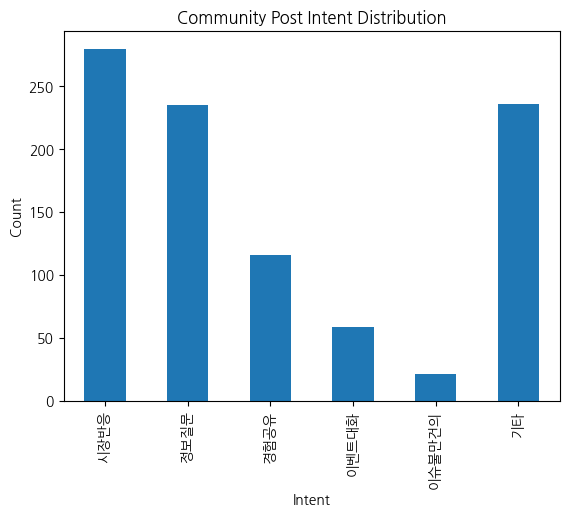

In [12]:
intent_order = ['시장반응','정보질문','경험공유','이벤트대화','이슈불만건의','기타']
counts = df['intent'].value_counts().reindex(intent_order)

counts.plot(kind='bar')

plt.title('Community Post Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

# 🌟 결론 🌟

커뮤니티 분석 결과, 대화 흐름은 시장반응을 중심으로 형성되며
정보질문과 경험공유가 이를 보조하는 구조로 나타났다.

이에 따라 비수기에는 신규 이벤트보다
상장 이후 흐름을 활용한 **회고형 밸런스게임 콘텐츠**와 <br>
사용자 참여를 유도하는 **경험공유 기반 자랑하기 콘텐츠**가
커뮤니티 체류를 유지하는 방향으로 적합하다고 판단하였다.